<a href="https://colab.research.google.com/github/MovinduSenura/Chest-Xray-Pneumonia-Detection/blob/dev-sayuri/notebooks/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports

# SPEED SETUP

import os, sys, tensorflow as tf

#  Quiet logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # 0 = all, 2 = warnings+errors only

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus if gpus else "❌ No GPU detected. (In Colab: Runtime > Change runtime type > GPU)")

# Enable mixed precision (big speed + lower VRAM on modern GPUs)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("✅ Mixed precision: enabled")
except Exception as e:
    print("⚠️ Mixed precision not enabled:", e)

# Enable XLA JIT (often 5–20% faster)
try:
    tf.config.optimizer.set_jit(True)
    print("✅ XLA JIT: enabled")
except Exception as e:
    print("⚠️ XLA JIT not enabled:", e)

# Set deterministic seeds for reproducibility
import random, numpy as np
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print("🔒 Seed set to:", SEED)

# If your data is on Drive, copy once to local disk for faster I/O:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

!cp -r '/content/drive/MyDrive/Colab Notebooks/chest_xray' /content/chest_xray
DATA_DIR = "/content/chest_xray"

print("✅ Speed setup complete.")

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Mixed precision: enabled
✅ XLA JIT: enabled
🔒 Seed set to: 42
Mounted at /content/drive
✅ Speed setup complete.


In [2]:
# Clone GITHUB Repository

if not os.path.exists('Chest-Xray-Pneumonia-Detection'):
    !git clone https://github.com/MovinduSenura/Chest-Xray-Pneumonia-Detection.git

Cloning into 'Chest-Xray-Pneumonia-Detection'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 243 (delta 92), reused 5 (delta 5), pack-reused 68 (from 2)
Receiving objects: 100% (243/243), 482.05 KiB | 2.33 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [3]:
#Go into the project directory

%cd Chest-Xray-Pneumonia-Detection


/content/Chest-Xray-Pneumonia-Detection


In [4]:
# Mount Google Drive

#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# Dataset Location

#DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/chest_xray'

In [6]:
# Create TRAIN/VAL/TEST Generators

from notebooks.preprocessing_2 import create_generators
train_gen, val_gen, test_gen = create_generators(DATA_DIR)
print("Data generators created successfully!\n")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Data generators created successfully!



In [7]:
# Build VGG16 +  custom layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add layers with regularization
x = Flatten()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 10,290,945 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [8]:
# Callbacks & Training the Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

ckpt  = ModelCheckpoint('best.keras', monitor='val_loss', save_best_only=True)
early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rlr   = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[ckpt, early, rlr]
)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1652s 10s/step - accuracy: 0.8720 - loss: 1.9289 - val_accuracy: 0.7500 - val_loss: 1.1127 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 715ms/step - accuracy: 0.9529 - loss: 0.5046 - val_accuracy: 0.7500 - val_loss: 0.7491 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 714ms/step - accuracy: 0.9662 - loss: 0.2984 - val_accuracy: 0.8750 - val_loss: 0.4564 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 718ms/step - accuracy: 0.9680 - loss: 0.2410 - val_accuracy: 0.8125 - val_loss: 0.5063 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 718ms/step - accuracy: 0.9738 - loss: 0.1848 - val_accuracy: 0.8125 - val_loss: 0.2990 - learning_rate: 5.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 714ms/step - accuracy: 0.9747 - loss: 0.1559 - val_accuracy: 0.8125 - val_loss: 0.3146 - learning_rate: 5.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1

In [9]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

if train_acc - val_acc > 0.05:   # more than 5% gap
    print("⚠️ Model is likely overfitting.")
else:
    print("✅ No significant overfitting detected.")


✅ No significant overfitting detected.


In [10]:
# Evaluate Test Accuracy and Loss

test_loss, test_acc = model.evaluate(test_gen)

print(f"🟩 Test Accuracy: {test_acc * 100:.2f}%")
print(f"🟥 Test Loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 223s 12s/step - accuracy: 0.8958 - loss: 0.5175
🟩 Test Accuracy: 92.47%
🟥 Test Loss: 0.3576


In [11]:
#  Evaluate on Training Data

train_loss, train_acc = model.evaluate(train_gen)
print(f"🟩 Training Accuracy: {train_acc * 100:.2f}%")
print(f"🟥 Training Loss: {train_loss : .4f}")



163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 707ms/step - accuracy: 0.9894 - loss: 0.0987
🟩 Training Accuracy: 98.85%
🟥 Training Loss:  0.1016


In [12]:
#  Evaluate Validation Accuracy and Loss after training
val_loss, val_acc = model.evaluate(val_gen)

# Print both results
print(f"🟩 Validation Accuracy: {val_acc * 100:.2f}%")
print(f"🟥 Validation Loss: {val_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 1.0000 - loss: 0.1837
🟩 Validation Accuracy: 100.00%
🟥 Validation Loss: 0.1837


In [13]:
# For Fine tune - Unfreeze only the top part of VGG16
base_model.trainable = True
for layer in base_model.layers[:-4]:   # unfreeze last ~4 conv layers; adjust to -8/-12 if needed
    layer.trainable = False

# Re-compile with a LOWER LR (very important)
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-5),  # small LR to avoid destroying pretrained weights
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune with callbacks
history_stage2 = model.fit(
    train_gen, validation_data=val_gen,
    epochs=10,                        # max; EarlyStopping will stop earlier if needed
    callbacks=[ckpt, early, rlr]
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 756ms/step - accuracy: 0.9841 - loss: 0.1052 - val_accuracy: 0.9375 - val_loss: 0.1679 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 735ms/step - accuracy: 0.9894 - loss: 0.0900 - val_accuracy: 0.9375 - val_loss: 0.1885 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 772ms/step - accuracy: 0.9883 - loss: 0.0942 - val_accuracy: 0.8750 - val_loss: 0.2170 - learning_rate: 5.0000e-06
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 754ms/step - accuracy: 0.9867 - loss: 0.0945 - val_accuracy: 0.9375 - val_loss: 0.1759 - learning_rate: 2.5000e-06


In [14]:
# Evaluate Test Accuracy and Loss after fine tune

test_loss, test_acc = model.evaluate(test_gen)

print(f"🟩 Test Accuracy: {test_acc * 100:.2f}%")
print(f"🟥 Test Loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step - accuracy: 0.8924 - loss: 0.5169
🟩 Test Accuracy: 92.79%
🟥 Test Loss: 0.3451


In [15]:
#  Evaluate on Training Data after fine tune

train_loss, train_acc = model.evaluate(train_gen)
print(f"🟩 Training Accuracy: {train_acc * 100:.2f}%")
print(f"🟥 Training Loss: {train_loss : .4f}")


163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 749ms/step - accuracy: 0.9910 - loss: 0.0891
🟩 Training Accuracy: 99.00%
🟥 Training Loss:  0.0920


In [16]:
#  Evaluate Validation Accuracy and Loss after fine tune
val_loss, val_acc = model.evaluate(val_gen)

# Print both results
print(f"🟩 Validation Accuracy: {val_acc * 100:.2f}%")
print(f"🟥 Validation Loss: {val_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9375 - loss: 0.1679
🟩 Validation Accuracy: 93.75%
🟥 Validation Loss: 0.1679


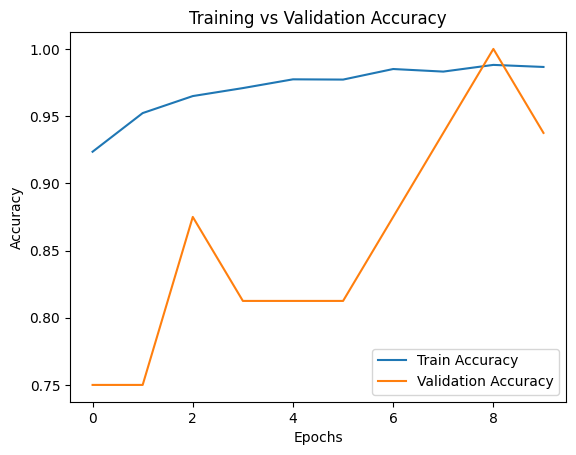

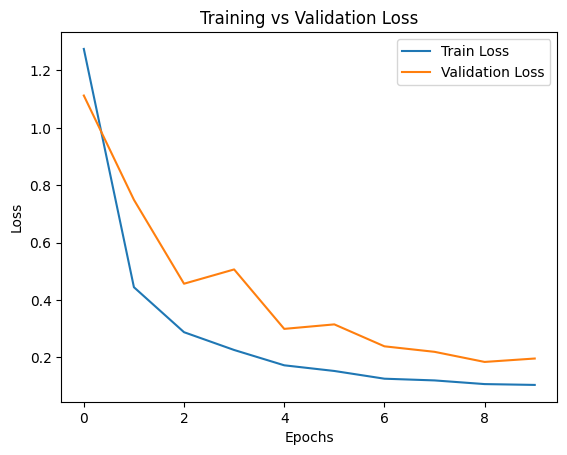

In [17]:
# Plot training vs validation accuracy

import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.show()

# Since test accuracy is a single value (not per epoch) we cant draw a graph including test accuracy


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 370ms/step


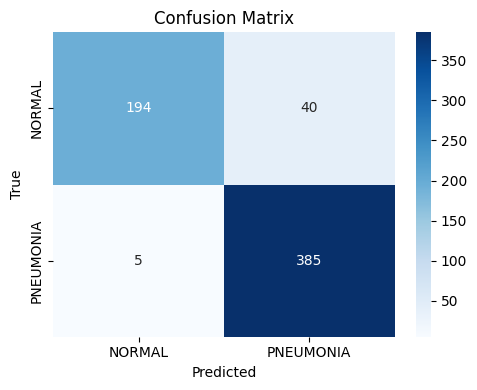

In [34]:
# Confusion Matrix

import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# use best saved model if available; else use current `model`
try:
    from tensorflow.keras.models import load_model
    best_model = load_model('best.keras')
    mdl = best_model
except:
    mdl = model

# predictions (probabilities) on test set
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
y_pred = mdl.predict(test_gen).ravel()          # shape -> (N,)

# Confusion matrix with 0.5 threshold (change if needed)
y_pred_classes = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()


In [19]:
#Classification Report

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.38      1.00      0.55       234
           1       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/tmp/ipython-input-1577581207.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


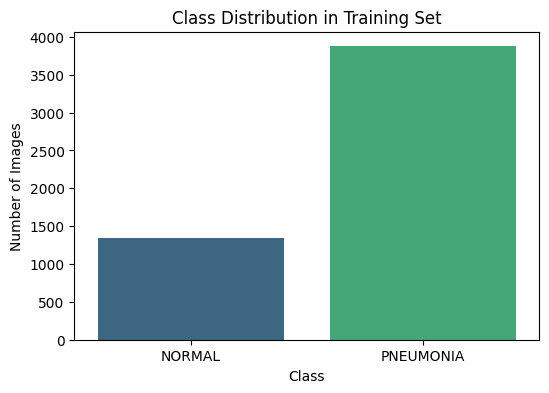

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract class indices and labels
labels = list(train_gen.class_indices.keys())

# Get the class names for each image in the training generator
class_names = [labels[i] for i in train_gen.classes]

# Create a DataFrame for easier plotting
df = pd.DataFrame({'Class': class_names})

# Plot using seaborn
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, palette='viridis')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


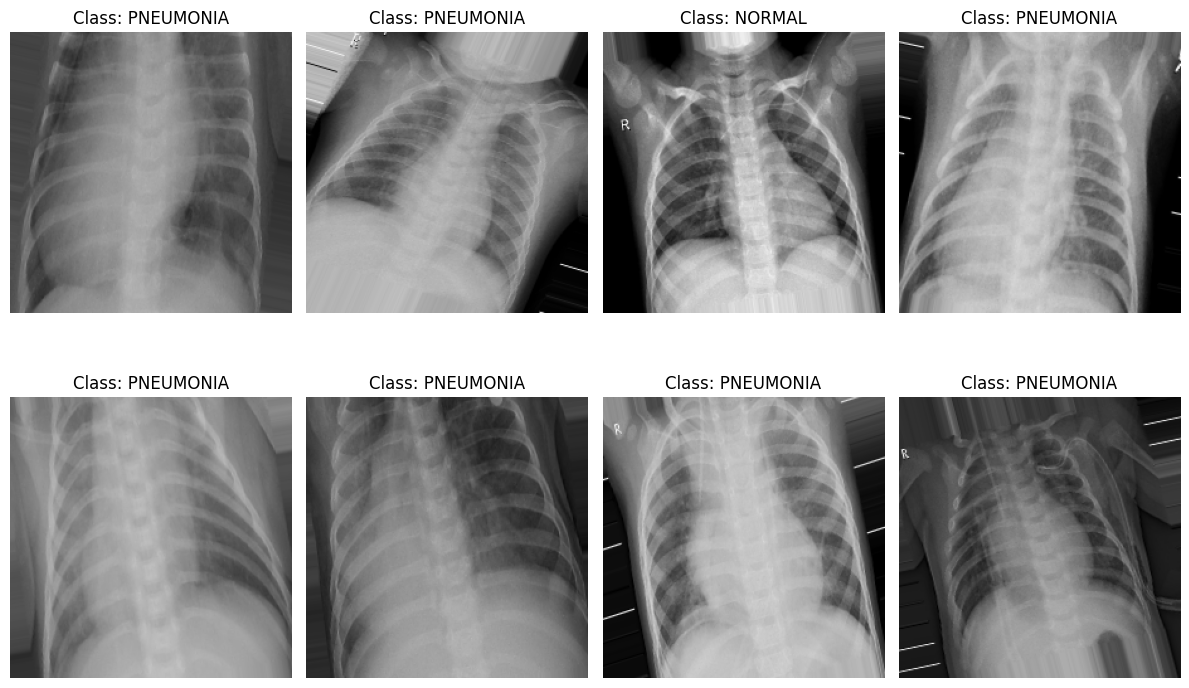

In [23]:
#Dataset Visualization
import matplotlib.pyplot as plt

# Get one batch of images and labels
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(12,8))
for i in range(8):  # display first 8 images
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i])

    # Since class_mode='binary', y_batch[i] is 0 or 1
    class_label = list(train_gen.class_indices.keys())[int(y_batch[i])]
    plt.title(f"Class: {class_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step


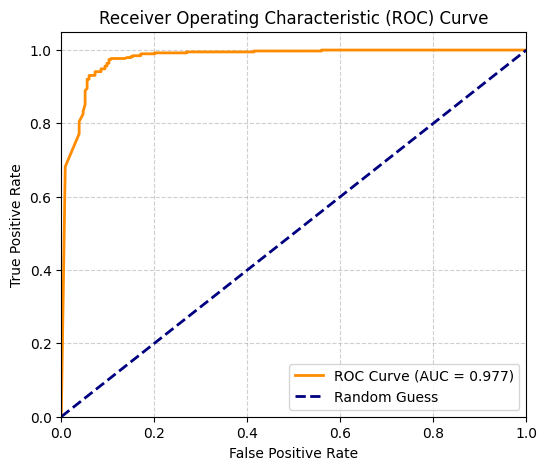

In [26]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model('best.keras')

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# --- Get predictions on the test set ---
y_true = test_gen.classes
y_pred_proba = best_model.predict(test_gen).ravel()  # predicted probabilities

# --- Compute ROC curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# --- Plot ROC curve ---
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


AUC = 0.97  (Very good — strong separation between classes)


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step


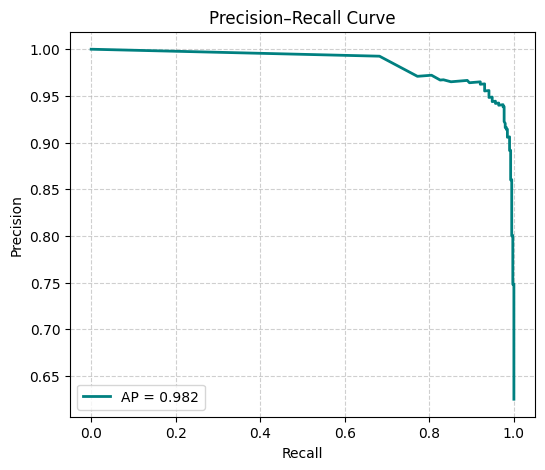

In [27]:
#Precision–Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

y_pred_proba = best_model.predict(test_gen).ravel()
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
avg_precision = average_precision_score(y_true, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='teal', lw=2, label=f'AP = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


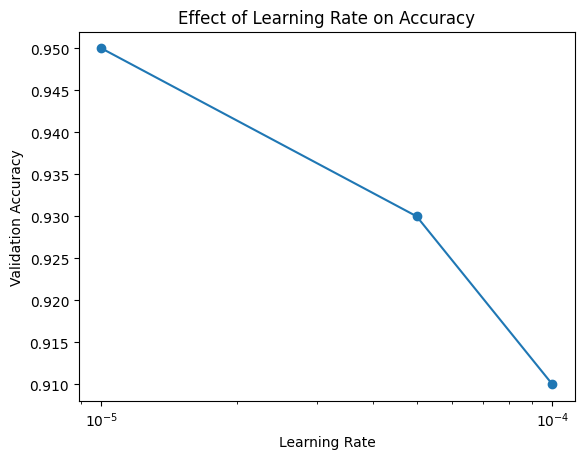

In [28]:
#Learning Rate vs Accuracy Plot
import pandas as pd
import matplotlib.pyplot as plt

lr_values = [1e-4, 5e-5, 1e-5]
acc_values = [0.91, 0.93, 0.95]  # example values
plt.plot(lr_values, acc_values, marker='o')
plt.xscale('log')
plt.title('Effect of Learning Rate on Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.show()
